<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/BRNN_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Labelling with a Bidirectional Recurrent Neural Network

## Google Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import tqdm

print("CUDA available: ", torch.cuda.is_available())

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device = torch.device(dev)  

CUDA available:  True


## Data loading

In [3]:
# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 3 # Name of the 3 files (train, dev y test) 
xf = 6

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

## Organize data

In [5]:
# Check number of phrases in transcripts
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

# Check number of phrases after splitting using the index array
data_set_train_phrases = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
data_set_test_phrases = np.split(data_set_test, data_end_index_test)[:-1]

print('Train: split data into {} phrases.'.format(len(data_set_train_phrases)))
print('Test: split data into {} phrases.'.format(len(data_set_test_phrases)))

Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [6]:
num_coef = 13

# Divide data into input (x) y output (y)
x_train = [data_set_train[:,:-1] for data_set_train in data_set_train_phrases]
y_train = [data_set_train[:,-1].transpose() for data_set_train in data_set_train_phrases]
x_test = [data_set_test[:,:-1] for data_set_test in data_set_test_phrases]
y_test = [data_set_test[:,-1].transpose() for data_set_test in data_set_test_phrases]

# Add batch dimension to inputs
x_train = [x.reshape((1, -1, num_coef )) for x in x_train]
x_test = [x.reshape(1, -1, num_coef) for x in x_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Transform to tensor
x_train = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_train]
y_train = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_train]
x_test = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_test]
y_test = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_test]

print('x_train shape: ', x_train[0].shape)
print('x_test shape: ', x_test[0].shape)

# Save in Device
x_train = [phrase.to(device) for phrase in x_train]
y_train = [phrase.to(device) for phrase in y_train]
x_test = [phrase.to(device) for phrase in x_test]
y_test = [phrase.to(device) for phrase in y_test]

# Get size of tran and test set
train_size = len(x_train)
test_size = len(x_test)

print("--Train data")
print("Number of samples: ", train_size)

print("--Test data")
print("Number of samples: ", test_size)

x_train shape:  (1, 90, 13)
x_test shape:  (1, 129, 13)
x_train shape:  torch.Size([1, 90, 13])
x_test shape:  torch.Size([1, 129, 13])
--Train data
Number of samples:  3696
--Test data
Number of samples:  192


## Define BRNN Class

In [7]:
class BRNN(nn.Module):
  def __init__(self, input_size, hidden_size, nr_layers, output_size):
    super(BRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.nr_layers = nr_layers # Recurrent layers

      # Hidden layer
    self.rnn = nn.RNN(self.input_size, self.hidden_size, self.nr_layers, batch_first=True, bidirectional=True, bias=True)
    
    # Output Layer
    self.fc = torch.nn.Linear(self.hidden_size*2, self.output_size, bias=True)

  def forward(self, x, hidden=None):
    batch_size = x.shape[0]

    if hidden is None:
      hidden = self.init_hidden(x)
    
    # Detach from its history
    hidden.detach_()

    out, hidden = self.rnn(x, hidden)
    out = self.fc(out.squeeze(0)) # TODO: is this okay, maybe I should use last t

    return out, hidden

  def init_hidden(self,x):
    return torch.zeros(self.nr_layers*2, x.size(0), self.hidden_size).requires_grad_().to(device)

## Instantiate BRNN model

In [8]:
NR_PHONEMES = 61
input_size = num_coef # Number of coefficients
hidden_size = 185 # Specified by Graves
output_size = NR_PHONEMES # Number of phonemes
layer_size = 2 # Two hidden layers


print("Creating a BRNN model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Layer size: ", layer_size)
print("Output size: ", output_size)

model = BRNN(input_size, hidden_size, layer_size, output_size)
model = model.to(device)

Creating a BRNN model with parameters:
Input size:  13
Hidden size:  185
Layer size:  2
Output size:  61


In [9]:
learning_rate = 10e-5 # Specified by Graves
momentum = 0.9

cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

## Evaluate model in test data

In [10]:
def evaluate_model(model, input_data, labels): # TODO: maybe this would be better as part of the class BRNN
  
  model.eval()
  
  total_loss = 0
  nr_correct_frames = 0
  nr_total_frames = 0
  
  hidden = None
  for (x_test_phrase, y_test_phrase) in zip(input_data, labels):
    #x_test_phrase = x_test_phrase.reshape(-1, x_test_phrase.size(0), input_size)
    output_test, _ = model(x_test_phrase, hidden)
  
    # Accumulate loss
    total_loss += cost_function(output_test, y_test_phrase)
  
    # Calculate number of correct frames
    y_prediction_test = torch.argmax(output_test, dim=1)
    nr_correct_frames += int((y_prediction_test == y_test_phrase).sum())
    nr_total_frames += len(y_test_phrase)
  
  # Arrange return values
  average_loss = total_loss/test_size
  average_loss = average_loss.item()
  
  perc_correct = nr_correct_frames/nr_total_frames*100
  
  return average_loss, perc_correct

In [11]:
average_loss, perc_correct = evaluate_model(model, x_test, y_test)

print('Loss:', average_loss)
print("Correct frames percentage: ", perc_correct)

Loss: 4.140477180480957
Correct frames percentage:  1.2016782057701272


### Training time

In [12]:
import time

nr_epochs = 20
epoch_losses_train = []
epoch_losses_test = []
epoch_correct_frames_train = []
epoch_correct_frames_test = []

start_time = time.time()
# TODO: initial weights? Graves: from flat distribution between -0.1 and 0.1
for epoch in range(nr_epochs):
  # TODO: put this inside a function
  print(f'EPOCH #{epoch+1}')
  #=========Train ==============#
  model.train()
  hidden = None
  # Variables used to get the percentage of correct frames
  nr_correct_frames = 0
  nr_total_frames = 0

  epoch_total_loss = 0

  # Randomize the order of phrases for each epoch
  random_idxs = np.random.permutation(train_size)
  
  for i in tqdm.notebook.tqdm(random_idxs):

    # At each batch, we detach the hidden state from how it was previously produced.
    # If we didn't, the model would try backpropagating all the way to the start of the dataset.
    model.zero_grad()

    # Forward pass
    y_pred, hidden = model(x_train[i], hidden)
    
    # Compute loss
    loss = cost_function(y_pred, y_train[i])
    epoch_total_loss += loss.item()

    # Get number of Correct franmes
    y_pred_labels = torch.argmax(y_pred, dim=1)
    nr_correct_frames += int((y_pred_labels == y_train[i]).sum())
    nr_total_frames += len(y_train[i])

    # Backward pass
    optimizer.zero_grad() # Clear grads before doing backward
    loss.backward()
    optimizer.step()
  
  # Epoch training results
  epoch_loss_train = epoch_total_loss/train_size
  perc_correct_train = nr_correct_frames/nr_total_frames*100
  print(f'Train loss: {epoch_loss_train}')
  print("Correct frames percentage: ", perc_correct_train)

  # =====See test results========#
  epoch_loss_test, perc_correct_test = evaluate_model(model, x_test, y_test)

  # Append epoch results 
  epoch_losses_train.append(epoch_loss_train)
  epoch_losses_test.append(epoch_loss_test)
  epoch_correct_frames_train.append(perc_correct_train)
  epoch_correct_frames_test.append(perc_correct_test)

  print()


print('Done training')
print()
end_time = time.time()

duration = end_time - start_time

print(f'Total training time: {duration} seconds')

EPOCH #1



Train loss: 3.3472252278810455
Correct frames percentage:  21.30255160145196

EPOCH #2



Train loss: 2.596972134431977
Correct frames percentage:  31.367868544651024

EPOCH #3



Train loss: 2.315563185293695
Correct frames percentage:  36.08025440447074

EPOCH #4



Train loss: 2.1787158600115157
Correct frames percentage:  39.13282356424077

EPOCH #5



Train loss: 2.0871815304412986
Correct frames percentage:  41.28534000460517

EPOCH #6



Train loss: 2.018139926031296
Correct frames percentage:  42.765572894579854

EPOCH #7



Train loss: 1.9658874626799578
Correct frames percentage:  43.908508271968124

EPOCH #8



Train loss: 1.9247692820345943
Correct frames percentage:  44.83745442616305

EPOCH #9



Train loss: 1.890453382326669
Correct frames percentage:  45.61757716547403

EPOCH #10



Train loss: 1.8604777380179016
Correct frames percentage:  46.35173711775097

EPOCH #11



Train loss: 1.8329614080907979
Correct frames percentage:  47.036200362190314

EPOCH #12



Train loss: 1.808529644494965
Correct frames percentage:  47.71995238361947

EPOCH #13



Train loss: 1.7851372122667826
Correct frames percentage:  48.31257895686699

EPOCH #14



Train loss: 1.763639422722193
Correct frames percentage:  48.86919986522324

EPOCH #15



Train loss: 1.741944821365984
Correct frames percentage:  49.454002985358585

EPOCH #16



Train loss: 1.7218626424734726
Correct frames percentage:  49.97995240140004

EPOCH #17



Train loss: 1.7025891598233414
Correct frames percentage:  50.494433346402054

EPOCH #18



Train loss: 1.6835948839396626
Correct frames percentage:  51.02696157528784

EPOCH #19



Train loss: 1.6651668079777973
Correct frames percentage:  51.500636100079745

EPOCH #20



Train loss: 1.6470162116345906
Correct frames percentage:  52.000714779125246

Done training

Total training time: 2472.415805578232 seconds


In [13]:
# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 'loss_test': epoch_losses_test, 'correct_frames_train': epoch_correct_frames_train, 'correct_frames_test': epoch_correct_frames_test, 'trainig_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/BRNN/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'
torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

In [18]:
print(epoch_info)

    Unnamed: 0  loss_train  ...  correct_frames_test  trainig_duration
0            0    3.347225  ...             2.898131       2472.415806
1            1    2.596972  ...             2.517277       2472.415806
2            2    2.315563  ...             2.355613       2472.415806
3            3    2.178716  ...             2.266910       2472.415806
4            4    2.087182  ...             2.207823       2472.415806
5            5    2.018140  ...             2.170349       2472.415806
6            6    1.965887  ...             2.140277       2472.415806
7            7    1.924769  ...             2.120947       2472.415806
8            8    1.890453  ...             2.093815       2472.415806
9            9    1.860478  ...             2.077107       2472.415806
10          10    1.832961  ...             2.051522       2472.415806
11          11    1.808530  ...             2.026490       2472.415806
12          12    1.785137  ...             2.020902       2472.415806
13    

In [14]:
# Load model
model = torch.load(model_filepath, map_location=device)
epoch_info = pd.read_csv(epoch_info_filepath)

### See Loss after training

In [15]:
# TODO make this a function!
# See the loss after training
model.eval()

total_loss = 0
nr_correct_frames = 0
nr_total_frames = 0

hidden = None
for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
  output_test, _ = model(x_test_phrase, hidden)
  total_loss += cost_function(output_test, y_test_phrase)

  # TODO: maybe using squeeze y unsqueeze
  # Correct samples
  y_prediction_test = torch.argmax(output_test, dim=1)
  nr_correct_frames += int((y_prediction_test == y_test_phrase).sum())
  nr_total_frames += len(y_test_phrase)

before_train_loss = total_loss/test_size
print('Before train Loss:', before_train_loss.item())

perc_correct = nr_correct_frames/nr_total_frames*100
print("Correct frames percentage: ", perc_correct)

Before train Loss: 1.9042723178863525
Correct frames percentage:  48.98047272915624


In [17]:
evaluate_model(model, x_test, y_test)

(1.9042723178863525, 48.98047272915624)

## Plots

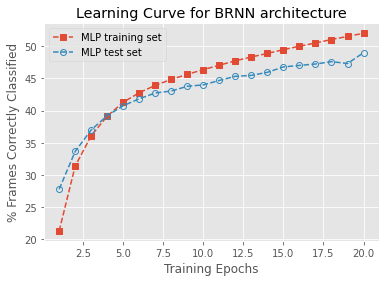

In [19]:
# Learning Curve

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()
epochs = np.arange(1,nr_epochs+1)
ax.plot(epochs, epoch_info['correct_frames_train'], '--s', label='MLP training set')
ax.plot(epochs, epoch_info['correct_frames_test'], '--o', markerfacecolor='None', label='MLP test set')

training_time = epoch_info['trainig_duration'][0]
ax.set(xlabel='Training Epochs', ylabel='% Frames Correctly Classified',
       title='Learning Curve for BRNN architecture')

learning_curve_filepath = root_path +'learning_curve_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

